In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import importlib
from matplotlib import rcParams
from plotnine import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
rcParams['axes.unicode_minus'] = False   # 正常显示负号

得到使用包的版本

In [77]:
# 包的列表
packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'plotnine', 'sklearn', 'statsmodels']

# 遍历包列表，导入包并打印版本
for package in packages:
    try:
        # 动态导入包
        module = importlib.import_module(package)
        # 打印包名和版本
        print(f"{package}: {module.__version__}")
    except ImportError:
        # 如果包不存在，则打印错误信息
        print(f"{package} is not installed.")
    except AttributeError:
        # 如果包没有__version__属性，则打印错误信息
        print(f"{package} does not have a __version__ attribute.")

numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.8.4
seaborn: 0.12.2
plotnine: 0.13.6
sklearn: 1.5.1
statsmodels: 0.14.2


# 数据处理与数据清洗

In [34]:
# 读取数据
music = pd.read_csv("music.csv", encoding='UTF-8')

## 删除重复值

In [35]:
# 查找重复值的布尔索引
duplicated_indices = music.duplicated()

# 获取重复值的索引
duplicate_rows_indices = music.index[duplicated_indices].tolist()
print("重复值的索引：", duplicate_rows_indices)

重复值的索引： [1084, 1085, 1086]


In [36]:
# 删除索引为 1085 和 1086 的行
music = music.drop([1085, 1086])

# 重置索引
music = music.reset_index(drop=True)

## 缺失值处理

In [37]:
# 查看缺失值
missing_per_column = music.isnull().sum()
print("每列缺失值数量：\n", missing_per_column)

每列缺失值数量：
 name               0
author             0
create_time        0
introduction     135
play_count         0
collect_count      0
share_count        0
comment_count      0
topics             0
fans               0
playlists          0
name_古风            0
name_BGM           0
name_经典            0
name_爵士            0
name_世界            0
name_精选            0
name_节奏            0
name_女声            0
name_欧美            0
name_粤语            0
name_民谣            0
name_东方            0
name_amp           0
name_中国            0
name_那些            0
dtype: int64


其中只有歌单介绍部分有135个缺失值，在后续处理时默认为无介绍

## 衍生变量

为了后续绘图方便，定义了绘图的类DataVisualizer，包含plot_histogram、plot_scatter、plot_boxplot三个函数，分别用户绘制频数分布直方图、带有趋势项的散点图和箱线图。

In [38]:
# 定义绘图的类
class DataVisualizer:
    def __init__(self, data):
        self.data = data

    # 绘制频数分布直方图，标题和坐标轴支持自动和自定义
    def plot_histogram(self, column, bins=10, title=None, xlabel=None, ylabel=None, subplot=None):
        if subplot:
            plt.subplot(*subplot)  # 如果传入子图位置参数，设置子图位置
        
        # 绘制直方图
        plt.hist(self.data[column], bins=bins, color='#0072CF', edgecolor='black', alpha=0.7)

        # 设置标题
        if title:
            plt.title(title, fontsize=10, fontweight='bold')
        else:
            plt.title(f'{column} 的分布', fontsize=10, fontweight='bold')

        # 设置x轴和y轴标签
        plt.xlabel(xlabel if xlabel else column, fontsize=10)
        plt.ylabel(ylabel if ylabel else '频数', fontsize=10)

        # 设置坐标轴的标签字体大小
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # 添加网格线
        plt.grid(True, linestyle='--', alpha=0.5)

    # 绘制带趋势线的散点图
    def plot_scatter(self, column_x, column_y, title=None, xlabel=None, ylabel=None, subplot=None):
        if subplot:
            plt.subplot(*subplot)  # 如果传入子图位置参数，设置子图位置
        
        # 绘制散点图和趋势线
        sns.regplot(
            x=self.data[column_x],
            y=self.data[column_y],
            scatter_kws={'color': '#0072CF', 'alpha': 0.7, 's': 5},  # 设置散点样式
            line_kws={'color': 'red', 'linewidth': 2.5}  # 设置趋势线样式
        )

        # 设置标题
        plt.title(
            title if title else f'{column_x} 和 {column_y} 的散点图（带趋势线）',
            fontsize=10,
            fontweight='bold',
            pad=15  # 增加标题与图表的间距
        )

        # 设置x轴和y轴标签
        plt.xlabel(xlabel if xlabel else column_x, fontsize=10, labelpad=10)
        plt.ylabel(ylabel if ylabel else column_y, fontsize=10, labelpad=10)

        # 设置坐标轴的标签字体大小
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # 添加网格线
        plt.grid(True, linestyle='--', alpha=0.5)

    # 绘制箱线图，支持子图
    def plot_boxplot(self, column_x, column_y, title=None, xlabel=None, ylabel=None, subplot=None):
        if subplot:
            plt.subplot(*subplot)  # 如果传入子图位置参数，设置子图位置
        
        sns.boxplot(
            x=self.data[column_x],
            y=np.log1p(self.data[column_y])
        )

        # 设置标题
        plt.title(title if title else f'{column_x} - 箱线图', fontsize=10, fontweight='bold')
        plt.xlabel(xlabel if xlabel else column_x, fontsize=10)
        plt.ylabel(ylabel if ylabel else '对数播放数', fontsize=10)

## 歌单名长度

对于歌单名本身的信息难以提取，这里选择歌单名长度用于信息提取。并根据歌单名长度的分布情况按10字符和20字符为节点将歌单名长度划分为”短”、“中”、“长”三类。

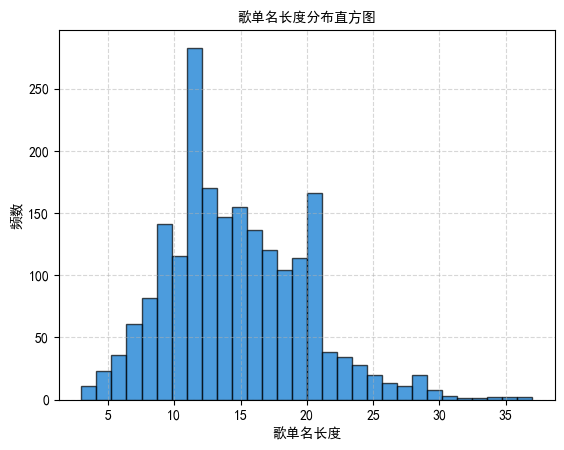

In [39]:
# 获取歌单名字符长度
music['name_length1'] = music['name'].str.len()

visualizer = DataVisualizer(music)
# 查看歌单名字符长度分布
visualizer.plot_histogram('name_length1', bins=30, title='歌单名长度分布直方图', xlabel='歌单名长度', ylabel='频数')

# 保存图片
plt.savefig('歌单名长度分布直方图.png', bbox_inches='tight', dpi=300)

In [40]:
# 根据长度划分为短、中、长三类
music['name_length2'] = pd.cut(
    music['name_length1'],
    bins=[-float('inf'), 10, 20, float('inf')],
    labels=["短", "中", "长"]
)


music[['name', 'name_length1', 'name_length2']].head()

,name,name_length1,name_length2
0,- Dance with me.,16,中
1,- Russian,9,短
2,-夜-車-歌-,7,短
3,：GOD'S DEATH 888【T% RAP】,24,长
4,??节奏狂??,7,短


In [41]:
# 处理为one-hot编码
top3_lengths = ['短', '中', '长']

# 使用 MultiLabelBinarizer 进行编码
mlb = MultiLabelBinarizer(classes=top3_lengths)

# 将 name_length2 列转换为列表形式，因为 MultiLabelBinarizer 需要每个标签是一个列表
music['name_length2'] = music['name_length2'].astype(str)

# 将 name_length2 转换为每个元素是单独列表的格式
music['name_length2_encoded'] = mlb.fit_transform(music['name_length2'].apply(lambda x: [x])).tolist()  # 保证为列表

# 展开为多个列
name_length_dummies = pd.DataFrame(music['name_length2_encoded'].tolist(), columns=mlb.classes_)

# 合并编码结果回 music 数据框
music = pd.concat([music.reset_index(drop=True), name_length_dummies.reset_index(drop=True)], axis=1)

# 删除多余的编码列（可选）
music.drop(columns=['name_length2_encoded'], inplace=True)

## 歌单简介长度

与歌单名类似，用歌单简介长度来代表歌单作者的用心程度。对于空值部分认为无介绍，对于有介绍部分，根据歌单简介长度分别划分为”50字符以内”，“51-150字符”，“150字符以上”三类。

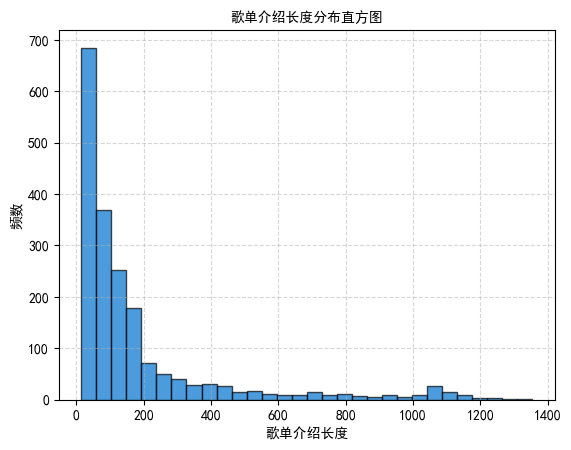

In [43]:
# 获取歌词简介长度
music['introduction_length1'] = music['introduction'].str.len()

# 绘制分布情况
visualizer = DataVisualizer(music)
visualizer.plot_histogram('introduction_length1', bins=30, title='歌单介绍长度分布直方图', xlabel='歌单介绍长度', ylabel='频数')

# 保存图片
plt.savefig('歌单介绍长度分布直方图.png', bbox_inches='tight', dpi=300)

In [44]:
# 判断是否有介绍
music['introduction_length2'] = np.where(
    music['introduction'].isna(),  # 判断是否为空
    "无介绍",                      # 空值分类为 "无介绍"
    pd.cut(
        music['introduction_length1'],
        bins=[-float('inf'), 50, 150, float('inf')],
        labels=["50字符以内", "51-150字符", "150字符以上"]
    )
)

music[['introduction', 'introduction_length1', 'introduction_length2']].head()

,introduction,introduction_length1,introduction_length2
0,<b>介绍：</b>欧美流行舞曲。<br>,21.0,50字符以内
1,<b>介绍：</b>边听边学俄语.<br>,21.0,50字符以内
2,<b>介绍：</b>今天我感到非常烦闷<br>我想念你<br>我想起夜幕降临的时候<br>和...,435.0,150字符以上
3,<b>介绍：</b>此歌单非常的躁动与迷幻 备 ：Rap Music 和 Trap Musi...,68.0,51-150字符
4,<b>介绍：</b>节奏感十足 *<br>,21.0,50字符以内


In [45]:
# 处理为one-hot编码
top4_lengths = ['无介绍', '50字符以内', '51-150字符','150字符以上']

# 使用 MultiLabelBinarizer 进行编码
mlb = MultiLabelBinarizer(classes=top4_lengths)

# 将 name_length2 列转换为列表形式，因为 MultiLabelBinarizer 需要每个标签是一个列表
music['introduction_length2'] = music['introduction_length2'].astype(str)

# 将 name_length2 转换为每个元素是单独列表的格式
music['introduction_length2_encoded'] = mlb.fit_transform(music['introduction_length2'].apply(lambda x: [x])).tolist()  # 保证为列表

# 展开为多个列
introduction_length_dummies = pd.DataFrame(music['introduction_length2_encoded'].tolist(), columns=mlb.classes_)

# 合并编码结果回 music 数据框
music = pd.concat([music.reset_index(drop=True), introduction_length_dummies.reset_index(drop=True)], axis=1)

# 删除多余的编码列（可选）
music.drop(columns=['introduction_length2_encoded'], inplace=True)

## 歌单创作天数

题目数据集中给的时间是时间戳，选取合适的时间为2019-11-06 14:53:25（根据狗熊会文章相关搜索，推测该数据集产生时间为2019年，为了更接近于真实情况，这里将时间戳选为2019年，而不是现在的时间。） 对应的时间戳为1573023205。二者相减来计算歌单创建的时长，单位为s。为了便于分析，将创建时长转为以“天”为单位计算。

In [46]:
music['time'] = 1573023205 - music['create_time']

# 将 'time' 列转换为天数（以秒为单位的时间差除以一天的秒数）
music['time1'] = (music['time'] / (24 * 60 * 60)).round()

# 查看结果
print(music[['create_time', 'time', 'time1']])

      create_time       time   time1
0      1393545600  179477605  2077.0
1      1404691200  168332005  1948.0
2      1463529600  109493605  1267.0
3      1421798400  151224805  1750.0
4      1484006400   89016805  1030.0
...           ...        ...     ...
2042   1450396800  122626405  1419.0
2043   1452470400  120552805  1395.0
2044   1434931200  138092005  1598.0
2045   1475625600   97397605  1127.0
2046   1435622400  137400805  1590.0

[2047 rows x 3 columns]


## 歌单话题

对于歌单话题该如何处理，一种方式是计算每个歌单歌单话题的数量；而是得到每个歌单话题下所对应的歌单数，找出top数据

不同话题数: 73


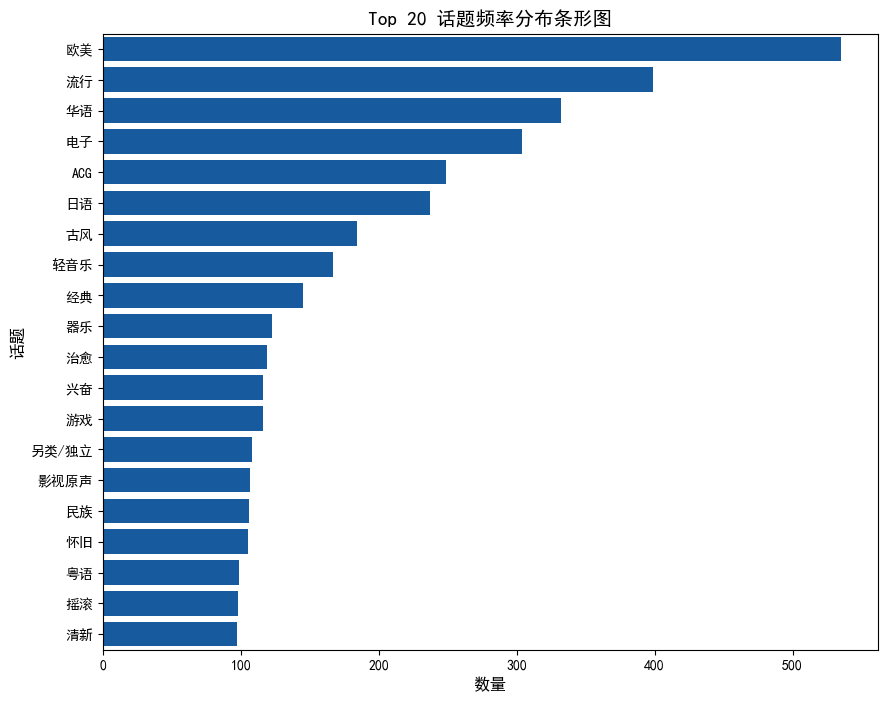

C:\Users\20377\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['00后', '70后', '80后', '90后', 'Bossa Nova', 'KTV', 'New Age', 'New?Age', 'R&amp;B/Soul', '下午茶', '世界音乐', '乡村', '伤感', '儿童', '午休', '古典', '吉他', '后摇', '地铁', '夜晚', '孤独', '学习', '安静', '小语种', '工作', '快乐', '思念', '性感', '感动', '拉丁', '放松', '散步', '旅行', '朋克', '校园', '榜单', '民谣', '浪漫', '清晨', '爵士', '网络歌曲', '翻唱', '舞曲', '英伦', '蓝调', '说唱', '运动', '酒吧', '金属', '钢琴', '雷鬼', '韩语', '驾车'] will be ignored


In [49]:
def parse_topics(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)  # 将字符串转换为列表
        return []
    except (ValueError, SyntaxError) as e:
        # 捕获 ValueError 和 SyntaxError 异常，并抛出一个新的异常
        raise ValueError(f"Invalid input for parsing topics: {x}") from e


# 解析 'topics' 列并创建新的列 'topics_parsed'
music['topics_parsed'] = music['topics'].apply(parse_topics)

# 统计每个歌单含有的话题数量
music['num_topics'] = music['topics_parsed'].apply(len)

# 得到不同话题的条形统计图
all_topics = [topic for topics in music['topics_parsed'] for topic in topics]
topic_counts = pd.Series(all_topics).value_counts()
print("不同话题数:", len(topic_counts))

# 选择出现频率最高的前20个话题
top20_topic_counts = topic_counts.head(20)

# 绘制前20个话题的横向条形图
plt.figure(figsize=(10, 8))
sns.barplot(y=top20_topic_counts.index, x=top20_topic_counts.values, color = '#005BB5')
plt.title('Top 20 话题频率分布条形图', fontsize=14, fontweight='bold')
plt.ylabel('话题', fontsize=12)
plt.xlabel('数量', fontsize=12)
# 保存图片
plt.savefig('TOP20话题频率分布条形图.png', bbox_inches='tight', dpi=300)
#图片展示
plt.show()

# 3. 对前20个话题进行 One-Hot 编码
top20_topics = topic_counts.head(20).index.tolist()  # 使用前20个话题

# 使用 MultiLabelBinarizer 对前20个话题进行 One-Hot 编码
mlb = MultiLabelBinarizer(classes=top20_topics)
topic_dummies = mlb.fit_transform(music['topics_parsed'])

# 将 One-Hot 编码后的数据转换为 DataFrame
topic_df = pd.DataFrame(topic_dummies, columns=mlb.classes_)

# 将 One-Hot 编码的数据合并到原始数据中
music = pd.concat([music, topic_df], axis=1)

## 数据对数化处理

In [50]:
# 对数值型变量做对数化处理
music['log_play_count'] = np.log1p(music['play_count'])
music['log_collect_count'] = np.log1p(music['collect_count'])
music['log_share_count'] = np.log1p(music['share_count'])
music['log_comment_count'] = np.log1p(music['comment_count'])
music['log_fans'] = np.log1p(music['fans'])
music['log_playlists'] = np.log1p(music['playlists'])
music['log_time1'] = np.log1p(music['time1'])

### 歌单播放量

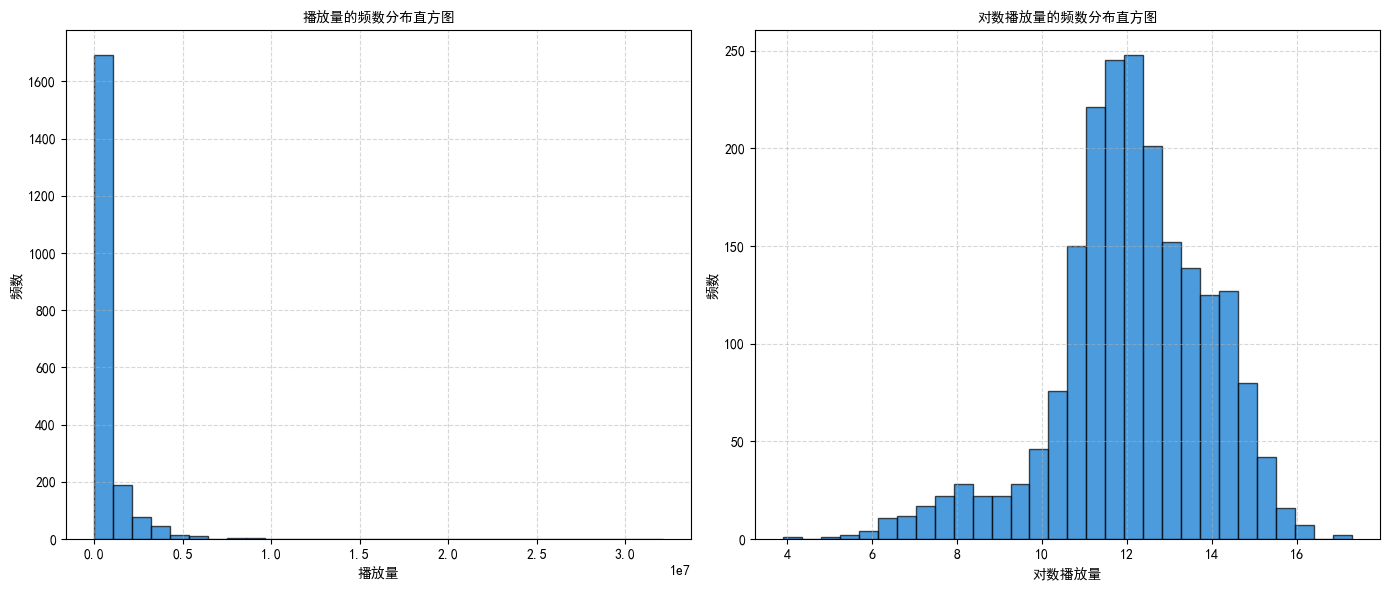

In [51]:
visualizer = DataVisualizer(music)
# 创建一个大的画布，准备两个子图
plt.figure(figsize=(14, 6))

# 绘制第一个子图：播放量的频数分布直方图
visualizer.plot_histogram('play_count', bins=30, title='播放量的频数分布直方图', xlabel='播放量', subplot=(1, 2, 1))

# 绘制第二个子图：对数播放量的频数分布直方图
visualizer.plot_histogram('log_play_count', bins=30, title='对数播放量的频数分布直方图', xlabel='对数播放量', subplot=(1, 2, 2))

# 显示调整好的子图布局
plt.tight_layout()  # 自动调整子图之间的间距

# 保存图片
plt.savefig('歌单播放量.png', bbox_inches='tight', dpi=300)

# 展示图片
plt.show()

对数播放量基本符合正态分布可用于后续分析。

### 给出收藏数、分享数、评论数、作者粉丝数、歌单歌曲数、歌单创作时长的频数分布直方图和对应的对数频数分布直方图

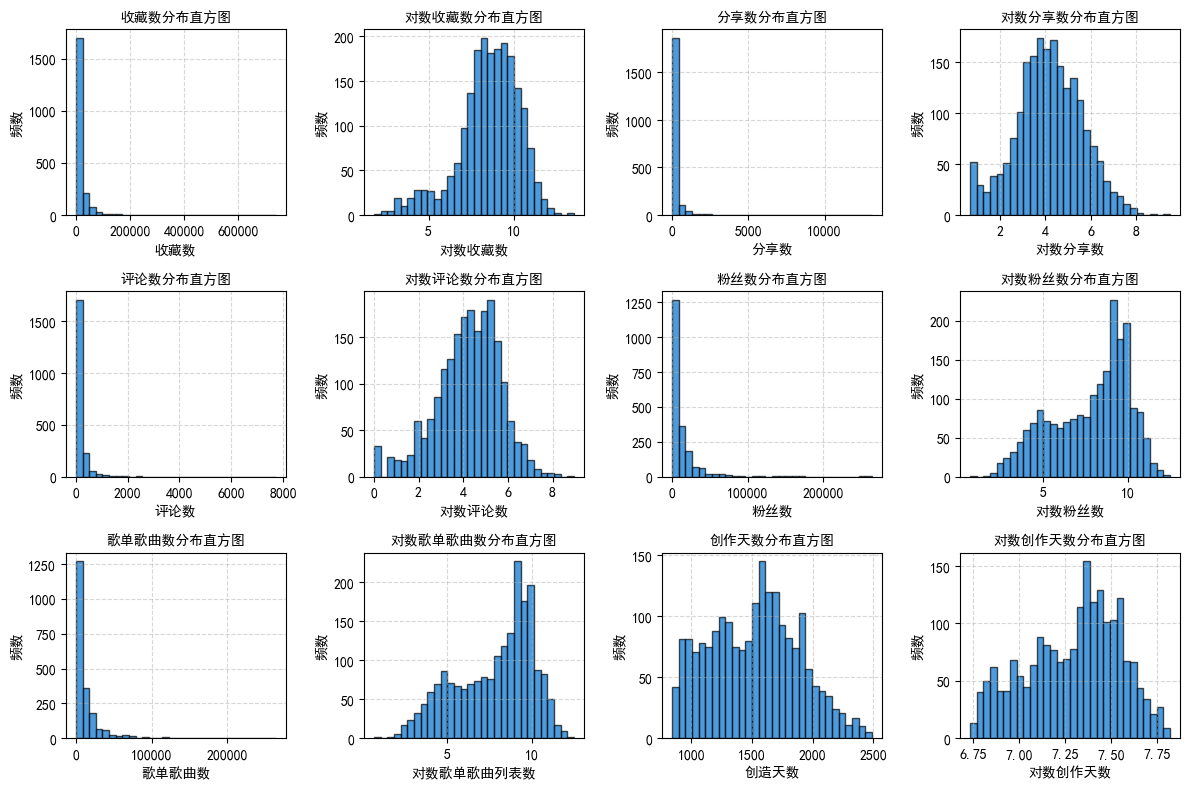

In [60]:
# 绘制3*4个图
plt.figure(figsize=(12, 8))

# 绘制收藏数的频数分布直方图和对数频数分布直方图
visualizer.plot_histogram('collect_count', bins=30, title='收藏数分布直方图', xlabel='收藏数', ylabel='频数', subplot=(3, 4, 1))
visualizer.plot_histogram('log_collect_count', bins=30, title='对数收藏数分布直方图', xlabel='对数收藏数', ylabel='频数', subplot=(3, 4, 2))

# 绘制分享数的频数分布直方图和散点图
visualizer.plot_histogram('share_count', bins=30, title='分享数分布直方图', xlabel='分享数', ylabel='频数', subplot=(3, 4, 3))
visualizer.plot_histogram('log_share_count', bins=30, title='对数分享数分布直方图', xlabel='对数分享数', ylabel='频数', subplot=(3, 4, 4))

# 绘制评论数的频数分布直方图和散点图
visualizer.plot_histogram('comment_count', bins=30, title='评论数分布直方图', xlabel='评论数', ylabel='频数', subplot=(3, 4, 5))
visualizer.plot_histogram('log_comment_count', bins=30, title='对数评论数分布直方图', xlabel='对数评论数', ylabel='频数', subplot=(3, 4, 6))

# 绘制作者粉丝数的频数分布直方图和散点图
visualizer.plot_histogram('fans', bins=30, title='粉丝数分布直方图', xlabel='粉丝数', ylabel='频数', subplot=(3, 4, 7))
visualizer.plot_histogram('log_fans', bins=30, title='对数粉丝数分布直方图', xlabel='对数粉丝数', ylabel='频数', subplot=(3, 4, 8))

# 绘制歌单列表数的频数分布直方图和散点图
visualizer.plot_histogram('fans', bins=30, title='歌单歌曲数分布直方图', xlabel='歌单歌曲数', ylabel='频数', subplot=(3, 4, 9))
visualizer.plot_histogram('log_fans', bins=30, title='对数歌单歌曲数分布直方图', xlabel='对数歌单歌曲列表数', ylabel='频数', subplot=(3, 4, 10))

# 绘制歌单列表数的频数分布直方图和散点图
visualizer.plot_histogram('time1', bins=30, title='创作天数分布直方图', xlabel='创造天数', ylabel='频数', subplot=(3, 4, 11))
visualizer.plot_histogram('log_time1', bins=30, title='对数创作天数分布直方图', xlabel='对数创作天数', ylabel='频数', subplot=(3, 4, 12))

# 调整布局
plt.tight_layout()

plt.savefig('其他连续变量的处理.png', bbox_inches='tight', dpi=300)
plt.show()

In [61]:
# 计算对数处理后数据的偏度
import numpy as np
from scipy.stats import skew

f1 = ['log_play_count','log_collect_count','log_share_count','log_comment_count','log_fans','log_playlists','log_time1']

# 计算偏度
for i in f1:
    skewness = skew(music[i])
    # 输出偏度
    print(f"数据的偏度为: {skewness}")

数据的偏度为: -0.6763626567970612
数据的偏度为: -0.811895059686614
数据的偏度为: -0.09695823752750106
数据的偏度为: -0.48766356861142723
数据的偏度为: -0.5572807439056365
数据的偏度为: 0.24400453658144913
数据的偏度为: -0.30223501061561125


数据在进行对数化处理后，都比较符合正态分布，对所有数值型变量均采用对数化后的数据进行分析，增加数据之间的区分度。

# 探索性分析

## 对数收藏数、对数分享数、对数评论数、对数作者粉丝数、对数歌单歌曲数、对数创作天数与对数播放量的散点图

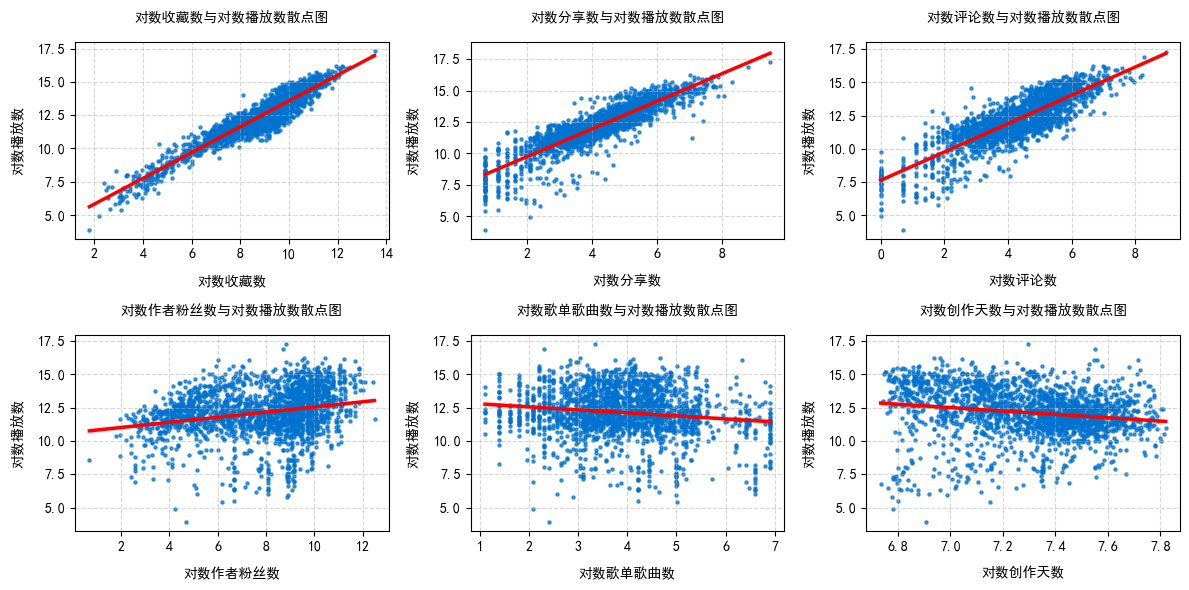

In [55]:
# 创建画布，设置大小
plt.figure(figsize=(12, 6))

# 绘制收藏数的频数分布直方图和散点图
visualizer.plot_scatter('log_collect_count', 'log_play_count', title='对数收藏数与对数播放数散点图', xlabel='对数收藏数',ylabel='对数播放数',subplot=(2, 3, 1))
# 绘制对数分享数的频数分布直方图和散点图
visualizer.plot_scatter('log_share_count', 'log_play_count', title='对数分享数与对数播放数散点图', xlabel='对数分享数',ylabel='对数播放数', subplot=(2, 3, 2))
# 绘制对数评论数的频数分布直方图和散点图
visualizer.plot_scatter('log_comment_count', 'log_play_count', title='对数评论数与对数播放数散点图', xlabel='对数评论数',ylabel='对数播放数', subplot=(2, 3, 3))
# 绘制对数作者粉丝数的频数分布直方图和散点图
visualizer.plot_scatter('log_fans', 'log_play_count', title='对数作者粉丝数与对数播放数散点图', xlabel='对数作者粉丝数',ylabel='对数播放数', subplot=(2, 3, 4))
# 绘制对数歌单列表数的频数分布直方图和散点图
visualizer.plot_scatter('log_playlists', 'log_play_count', title='对数歌单歌曲数与对数播放数散点图', xlabel='对数歌单歌曲数',ylabel='对数播放数', subplot=(2, 3, 5))
# 绘制对数歌单天数的频数分布直方图和散点图
visualizer.plot_scatter('log_time1', 'log_play_count', title='对数创作天数与对数播放数散点图', xlabel='对数创作天数',ylabel='对数播放数', subplot=(2, 3, 6))

# 调整布局
plt.tight_layout()
plt.savefig('散点图.png', bbox_inches='tight', dpi=300)
plt.show()

## 高频词与对数播放量的箱线图

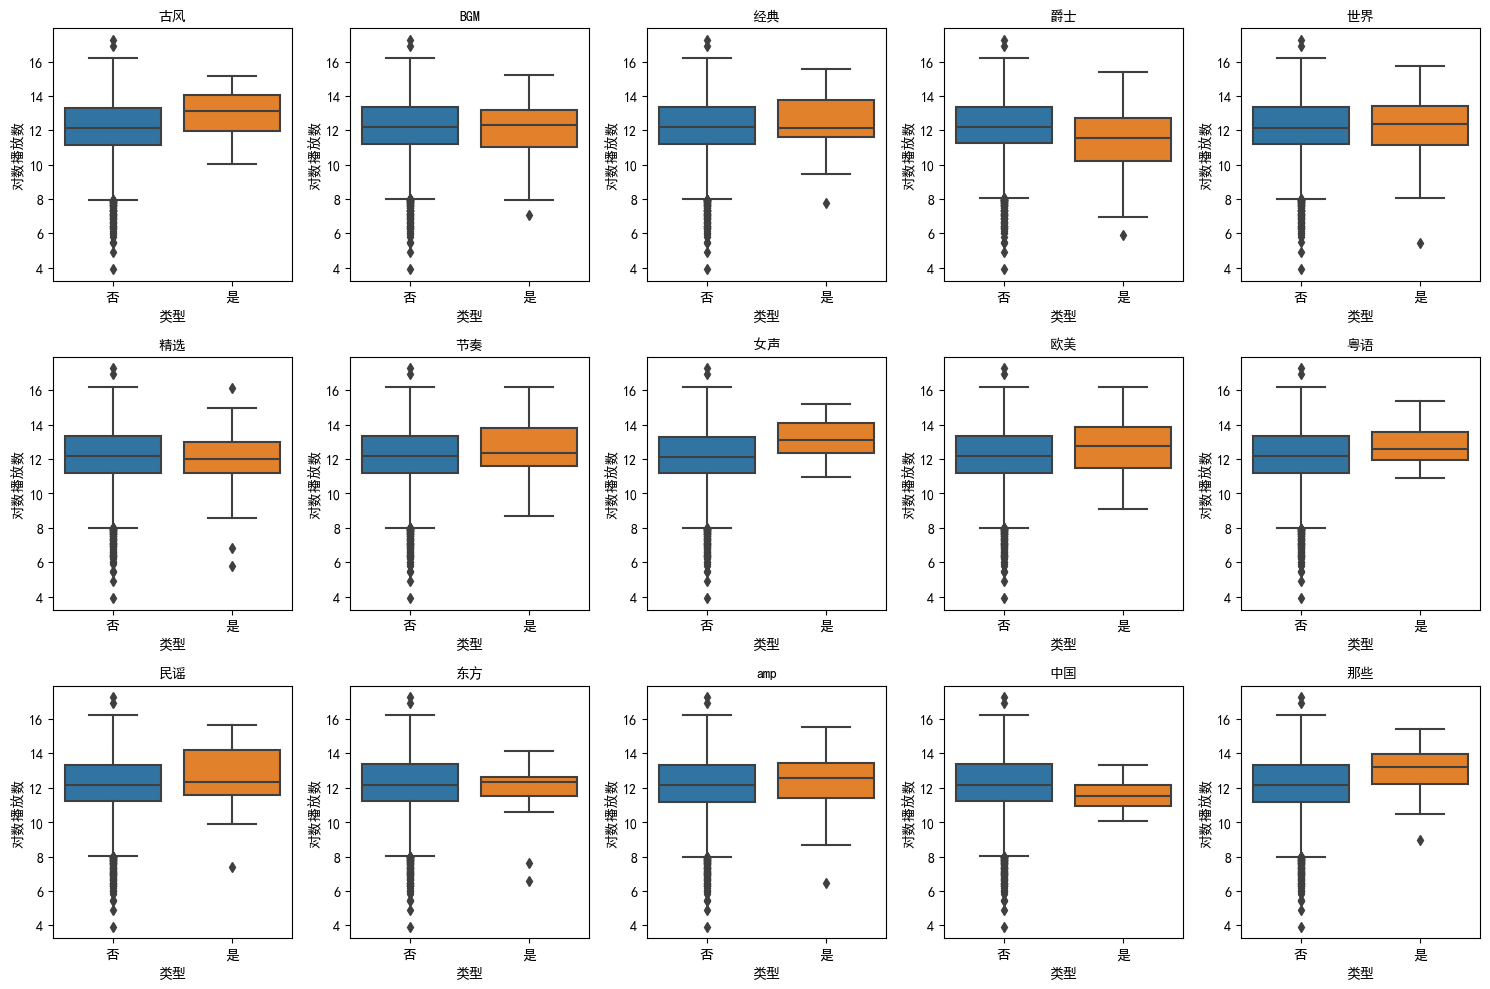

In [56]:
# 创建画布和子图
plt.figure(figsize=(15, 10))

# 分类名称
categories = ['name_古风', 'name_BGM', 'name_经典', 'name_爵士', 'name_世界', 
              'name_精选', 'name_节奏', 'name_女声', 'name_欧美', 'name_粤语', 
              'name_民谣', 'name_东方', 'name_amp', 'name_中国', 'name_那些']

# 使用循环绘制每个分类的箱线图
for i, category in enumerate(categories, 1):
    visualizer.plot_boxplot(column_x=category, column_y='play_count', 
                            title=category[5:], xlabel="类型", ylabel="对数播放数", subplot=(3, 5, i))

# 调整布局
plt.tight_layout()
plt.savefig('高频词箱线图.png', bbox_inches='tight', dpi=300)
# 显示图形
plt.show()

## 歌单名长度、歌单介绍长度与对数播放数箱线图

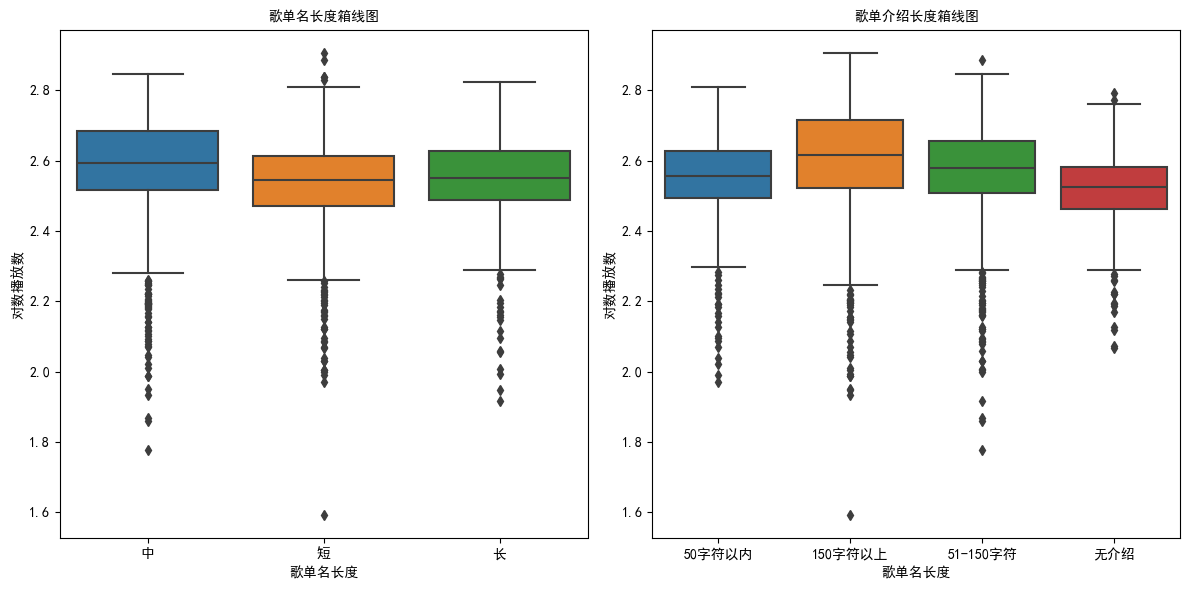

In [57]:
# 设置画布大小
plt.figure(figsize=(12, 6))

# 歌单名长度与对数播放数箱线图
visualizer.plot_boxplot('name_length2', 'log_play_count', title='歌单名长度箱线图', xlabel='歌单名长度', ylabel='对数播放数', subplot=(1, 2, 1))
# 歌单介绍长度与对数播放数箱线图
visualizer.plot_boxplot('introduction_length2', 'log_play_count', title='歌单介绍长度箱线图', xlabel='歌单名长度', ylabel='对数播放数', subplot=(1, 2, 2))

# 调整布局
plt.tight_layout()
plt.savefig('箱线图.png', bbox_inches='tight', dpi=300)
# 显示图形
plt.show()

# 模型建构 

## 数据处理

In [58]:
# 打印所有列名
print(music.columns)

Index(['name', 'author', 'create_time', 'introduction', 'play_count',
       'collect_count', 'share_count', 'comment_count', 'topics', 'fans',
       'playlists', 'name_古风', 'name_BGM', 'name_经典', 'name_爵士', 'name_世界',
       'name_精选', 'name_节奏', 'name_女声', 'name_欧美', 'name_粤语', 'name_民谣',
       'name_东方', 'name_amp', 'name_中国', 'name_那些', 'name_length1',
       'name_length2', '短', '中', '长', 'introduction_length1',
       'introduction_length2', '无介绍', '50字符以内', '51-150字符', '150字符以上', 'time',
       'time1', 'topics_parsed', 'num_topics', '欧美', '流行', '华语', '电子', 'ACG',
       '日语', '古风', '轻音乐', '经典', '器乐', '治愈', '兴奋', '游戏', '另类/独立', '影视原声', '民族',
       '怀旧', '粤语', '摇滚', '清新', 'log_play_count', 'log_collect_count',
       'log_share_count', 'log_comment_count', 'log_fans', 'log_playlists',
       'log_time1'],
      dtype='object')


In [62]:
# 将高频词转为0-1变量
columns = [
    'name_古风', 'name_BGM', 'name_经典', 'name_爵士', 'name_世界',
    'name_精选', 'name_节奏', 'name_女声', 'name_欧美', 'name_粤语', 'name_民谣',
    'name_东方', 'name_amp', 'name_中国', 'name_那些'
]

# 将指定列中的 '是' 替换为 1，'否' 替换为 0
music[columns] = music[columns].replace({'是': 1, '否': 0})

In [63]:
# 得出用于分析的数据集-去除name,author,create_time,introduction,play_count,topics,name_length1,has_introduction,introduction_length1,time,topics_parsed
mymusic = music.drop(columns=['name', 'author', 'create_time', 'introduction', 'play_count','collect_count', 'share_count',
                              'comment_count', 'topics', 'fans','playlists','name_length1','name_length2', 'introduction_length1', 
                              'introduction_length2', 'time','time1', 'topics_parsed', 'num_topics'])

# 选择用于分析的特征列和目标列
x = mymusic.drop(columns=['log_play_count'])  # 特征列
y = mymusic['log_play_count']  # 目标列
x

,name_古风,name_BGM,name_经典,name_爵士,name_世界,name_精选,name_节奏,name_女声,name_欧美,name_粤语,...,怀旧,粤语,摇滚,清新,log_collect_count,log_share_count,log_comment_count,log_fans,log_playlists,log_time1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7.666222,3.688879,3.970292,8.695339,3.135494,7.639161
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7.289611,2.639057,2.772589,9.750569,4.859812,7.575072
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9.235716,5.379897,5.308268,9.016513,3.951244,7.145196
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8.246958,4.189655,4.110874,5.627621,2.197225,7.467942
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,5.860786,2.484907,2.302585,7.375256,3.258097,6.938284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7.936303,3.583519,3.465736,8.575273,2.079442,7.258412
2043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8.754949,4.897840,5.036953,8.916640,3.637586,7.241366
2044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6.921658,2.639057,2.708050,6.190315,3.970292,7.377134
2045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10.497864,7.070724,5.652489,11.873658,2.397895,7.028201


## 多元线性回归

In [69]:
# 为了避免多重共线性，去除掉短和无介绍，作为基变量
x_regression = x.drop(columns=['短','无介绍'])

# 创建线性回归模型
model = LinearRegression()

# 计算5折交叉验证的R²评分：
cv_r2_scores = cross_val_score(model, x_regression, y, cv=5, scoring='r2')
print(f'每折的R²得分：{cv_r2_scores}')
print(f'平均R²得分：{cv_r2_scores.mean()}')

# 使用 MAE 作为评分指标进行 5 折交叉验证
mae_scores = cross_val_score(model, x_regression, y, cv=5, scoring='neg_mean_absolute_error')

# 由于 `cross_val_score` 返回的是负值，需要取负数才能得到 MAE
mae_scores = -mae_scores

# 输出 MAE 结果
print(f'每折的 MAE：{mae_scores}')
print(f'平均 MAE：{mae_scores.mean()}')

# 使用 statsmodels 进行回归分析，获取回归系数和显著性
X = sm.add_constant(x_regression)  # 添加常数项（截距）
sm_model = sm.OLS(y, X)  # 进行线性回归拟合
results = sm_model.fit()  # 拟合模型

# 筛选 p-value 小于 0.05 的回归系数
significant_params = results.params[results.pvalues < 0.05]
print(f'显著性(p-value < 0.05)变量及其回归系数：\n{significant_params}')

# 计算 R² 得分
r2_score = results.rsquared
print(f'模型的 R² 得分：{r2_score}')

# 得到模型的F统计量及其对应的p值
f_statistic = results.fvalue  # F 统计量
f_p_value = results.f_pvalue  # F 统计量的 p 值

print(f'F 统计量: {f_statistic:.4f}')
print(f'F 统计量的 p 值: {f_p_value:.4e}')  # 以科学计数法（指数形式）显示

每折的R²得分：[0.93506092 0.93752076 0.91000814 0.92169983 0.93214436]
平均R²得分：0.9272867993455304
每折的 MAE：[0.33940175 0.36901664 0.38131769 0.39816877 0.37438261]
平均 MAE：0.372457494849145
显著性(p-value < 0.05)变量及其回归系数：
const                7.785612
name_节奏              0.150142
name_女声              0.163952
name_欧美              0.153085
name_粤语              0.249204
name_民谣              0.204269
name_东方             -0.657653
name_amp             0.165016
name_那些              0.176747
中                   -0.065308
长                   -0.136552
150字符以上             -0.128874
流行                   0.134520
华语                   0.315458
日语                  -0.351573
古风                  -0.474937
器乐                  -0.123630
游戏                  -0.196091
粤语                   0.198624
清新                   0.145695
log_collect_count    0.833706
log_share_count      0.146707
log_playlists       -0.071800
log_time1           -0.431716
dtype: float64
模型的 R² 得分：0.933108699003932
F 统计量: 606.5055
F 统计量的 p 值:

## RF（随机森林）

In [72]:
def train_random_forest(x, y, test_size=0.3, random_state=42, n_iter=100, cv=5, n_jobs=-1):
    """
    使用随机森林回归器训练模型并进行超参数调优，并直接输出评估结果。

    参数：
    x (pd.DataFrame 或 np.ndarray): 特征数据
    y (pd.Series 或 np.ndarray): 目标变量
    test_size (float): 测试集的比例，默认 0.3
    random_state (int): 随机种子，默认 42
    n_iter (int): 随机搜索的迭代次数，默认 100
    cv (int): 交叉验证的折数，默认 5
    n_jobs (int): 并行作业的数量，默认 -1 表示使用所有可用核心
    """
    
    # 划分数据集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    # 定义参数分布
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # 初始化随机森林模型
    rf = RandomForestRegressor(random_state=random_state)
    
    # 使用 RandomizedSearchCV 进行超参数调优，采用 cv 折交叉验证
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        verbose=2,
        random_state=random_state,
        n_jobs=n_jobs,
        error_score='raise'
    )
    
    # 训练模型
    random_search.fit(x_train, y_train)
    
    # 输出最佳参数
    print("最佳参数：", random_search.best_params_)
    
    # 在测试集上进行预测
    y_pred = random_search.best_estimator_.predict(x_test)
    
    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 输出评估结果
    print("平均绝对误差 (MAE)：", mae)
    print("R² 得分：", r2)

In [73]:
# 使用所有数据
train_random_forest(x,y)

# 仅使用F1数据
x_f1 = x[['log_collect_count', 'log_share_count', 'log_comment_count']]
train_random_forest(x_f1,y)

# 使用F1+F2+F3数据
x_dropf4 = x.drop(columns=['短', '中', '长', '无介绍', '50字符以内', '51-150字符', '150字符以上'])
train_random_forest(x_dropf4,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳参数： {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
平均绝对误差 (MAE)： 0.35069699495028855
R² 得分： 0.9449158208873716
Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳参数： {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
平均绝对误差 (MAE)： 0.41134302723430327
R² 得分： 0.9255575629046929
Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳参数： {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
平均绝对误差 (MAE)： 0.3526489091040679
R² 得分： 0.9433992123079754
